<a href="https://colab.research.google.com/github/Osterne/codes_book/blob/main/Episodio_01_Partial_Dependence_Plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Data Science Podcast (por Vinícius Osterne)
## Episódio 01 - Partial Dependence Plot

## Sobre o problema

Quando trabalhamos com modelos de árvore, como o GBM, é comum alguém olhar para um atributo na base de dados e pensar: 'Ah, essa variável parece importante porque, em média, valores altos aumentam a resposta…' Mas isso é um erro clássico.

A verdade é que o modelo pode estar interpretando esse atributo de uma forma completamente diferente do que vemos olhando só para os dados crus. E é aí que entra o Partial Dependence Plot, ou PDP.

## Exemplo fictício:

*   Número de transações nas últimas 24h – Detecta padrões anormais de atividade.
*   Número de dispositivos diferentes usados para login – Indica possível comprometimento de conta.
*   Tentativas de senha incorreta – Comportamento típico de ataques ou fraude.

## Análise

In [17]:
!pip install h2o

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 4.4 MB/s eta 0:00:00


In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import h2o
from h2o.estimators import H2OGradientBoostingEstimator

In [28]:
# ===============================
# 1. Criar base artificial
# ===============================
import numpy as np
import pandas as pd

np.random.seed(42)
n_samples = 2000

# Variáveis comportamentais
transacoes_24h = np.random.poisson(lam=2, size=n_samples)               # discreta
dispositivos = np.random.randint(1, 5, n_samples)                       # discreta
tentativas_senha = np.random.poisson(lam=1, size=n_samples)              # discreta

# Variáveis contínuas
tempo_sessao = np.random.exponential(scale=300, size=n_samples)          # tempo de sessão em segundos
valor_medio_transacao = np.random.normal(loc=500, scale=200, size=n_samples)  # valor médio em R$

# Ajuste para manter valores positivos
valor_medio_transacao = np.clip(valor_medio_transacao, 50, None)

# Lógica da fraude:
# - Fraudes ocorrem com muitas tentativas de senha e dispositivos diferentes
# - Pouquíssimas transações (fraude discreta)
# - Sessão muito longa ou valor médio muito alto também aumenta risco
fraude = (
    ((tentativas_senha > 2) & (dispositivos > 2)) |
    ((transacoes_24h < 1) & (tentativas_senha > 0)) |
    (tempo_sessao > 800) |
    (valor_medio_transacao > 1000)
).astype(int)

df = pd.DataFrame({
    'transacoes_24h': transacoes_24h,
    'dispositivos': dispositivos,
    'tentativas_senha': tentativas_senha,
    'tempo_sessao': tempo_sessao,
    'valor_medio_transacao': valor_medio_transacao,
    'fraude': fraude
})

df.head(5)

,transacoes_24h,dispositivos,tentativas_senha,tempo_sessao,valor_medio_transacao,fraude
0,4,3,1,662.496647,50.000000,0
1,1,1,1,587.797207,499.227544,0
2,3,2,0,23.949215,385.474599,0
3,3,4,0,33.745217,529.163620,0
4,1,1,1,205.061008,718.525513,0


In [3]:
df.head(5)

,transacoes_24h,dispositivos,tentativas_senha,fraude
0,2,4,3,1
1,3,3,1,0
2,0,3,1,1
3,3,4,2,0
4,2,4,0,0


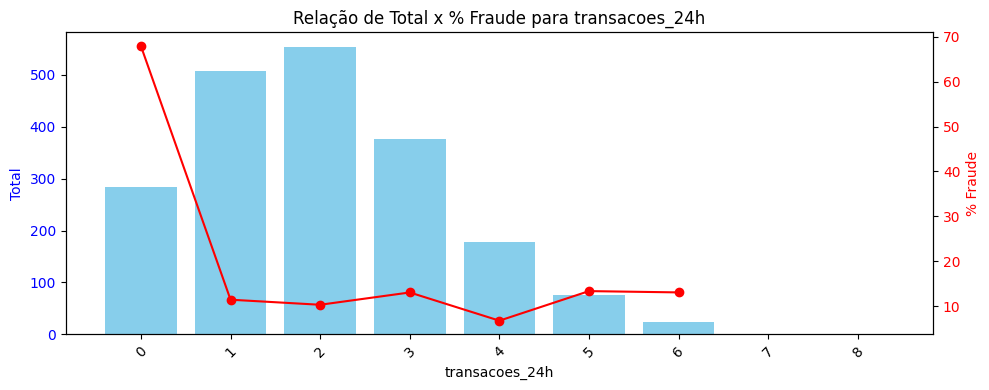

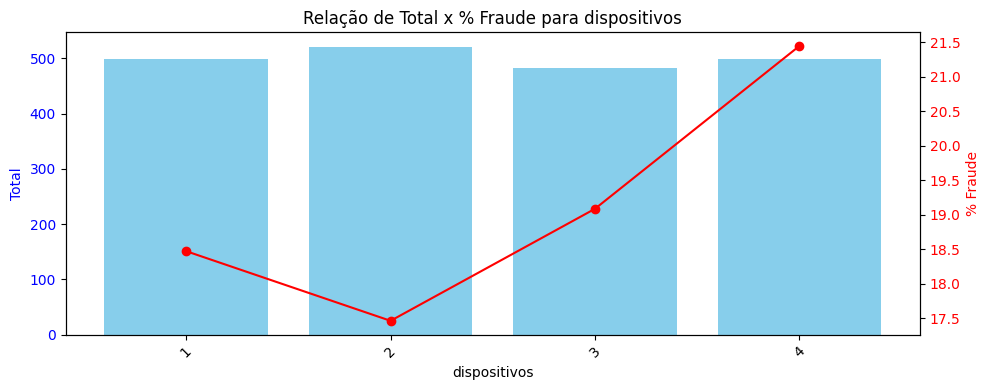

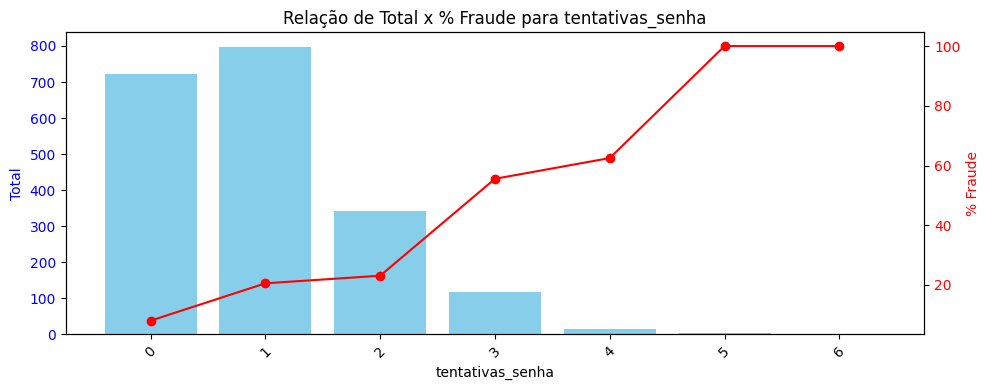

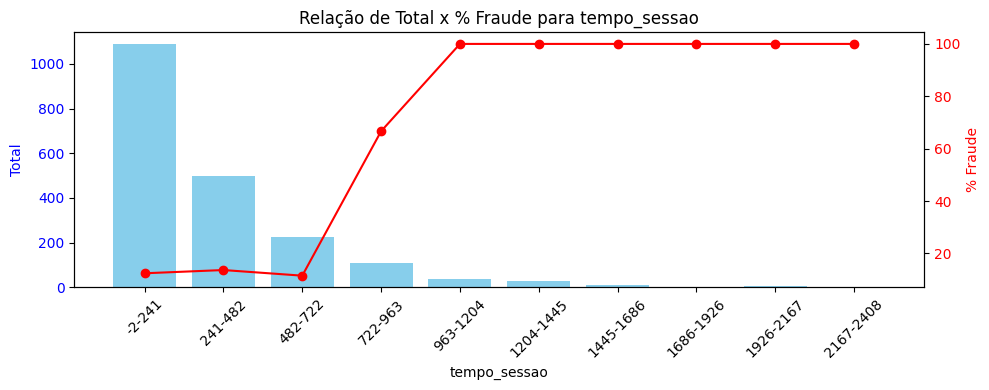

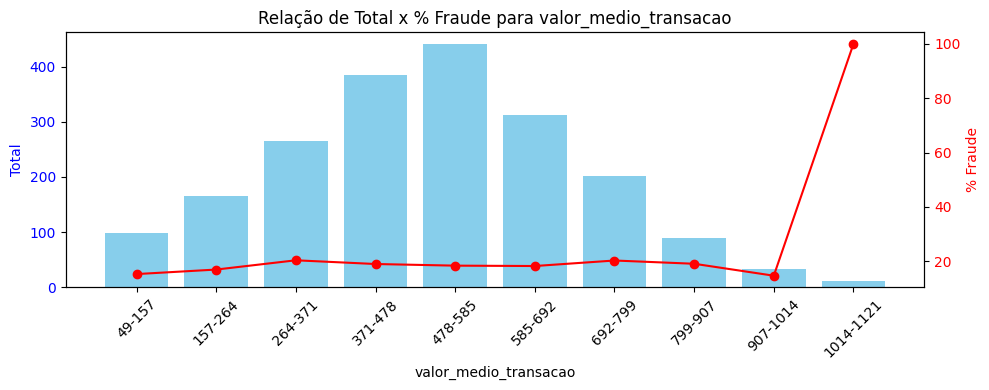

In [30]:
# ===============================
# 2. Análise descritiva
# ===============================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_bivariada_misto(df, variavel, bins=10):
    # Se a variável for contínua, criar faixas
    if pd.api.types.is_numeric_dtype(df[variavel]) and df[variavel].nunique() > 20:
        df_plot = df.copy()
        df_plot[variavel + '_bin'] = pd.cut(df_plot[variavel], bins=bins)
        total = df_plot[variavel + '_bin'].value_counts().sort_index()
        pct_fraude = (
            df_plot[df_plot['fraude'] == 1][variavel + '_bin'].value_counts().sort_index()
            / total
        ) * 100
        x_labels = [f"{interval.left:.0f}-{interval.right:.0f}" for interval in total.index]
    else:
        total = df[variavel].value_counts().sort_index()
        pct_fraude = (
            df[df['fraude'] == 1][variavel].value_counts().sort_index() / total
        ) * 100
        x_labels = total.index.astype(str)

    # Criando gráfico misto
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Barras - Total
    ax1.bar(range(len(total)), total.values, color='skyblue', label='Total')
    ax1.set_xlabel(variavel)
    ax1.set_ylabel('Total', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xticks(range(len(total)))
    ax1.set_xticklabels(x_labels, rotation=45)

    # Linha - % Fraude
    ax2 = ax1.twinx()
    ax2.plot(range(len(pct_fraude)), pct_fraude.values, color='red', marker='o', label='% Fraude')
    ax2.set_ylabel('% Fraude', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f'Relação de Total x % Fraude para {variavel}')
    fig.tight_layout()
    plt.show()

# Gerar gráfico misto para todas as variáveis
plot_bivariada_misto(df, 'transacoes_24h')
plot_bivariada_misto(df, 'dispositivos')
plot_bivariada_misto(df, 'tentativas_senha')
plot_bivariada_misto(df, 'tempo_sessao')
plot_bivariada_misto(df, 'valor_medio_transacao')


In [31]:
# ===============================
# 3. Treinar modelo GBM
# ===============================
# Iniciar H2O
h2o.init()

# Converter o dataframe para H2OFrame
hf = h2o.H2OFrame(df)

# Definir features e target (agora incluindo as contínuas)
features = [
    'transacoes_24h',
    'dispositivos',
    'tentativas_senha',
    'tempo_sessao',
    'valor_medio_transacao'
]
target = 'fraude'

# Converter target para categórico (fator)
hf[target] = hf[target].asfactor()

# Treinar modelo GBM
gbm_model = H2OGradientBoostingEstimator(
    ntrees=100,
    max_depth=3,
    learn_rate=0.1,
    seed=42
)
gbm_model.train(x=features, y=target, training_frame=hf)

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,3 mins 19 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,4 months and 2 days
H2O_cluster_name:,H2O_from_python_unknownUser_yegouj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1753825697886_103


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                100                         14623                  3            3            3             5             8             6.96

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 1.5948371500644653e-05
RMSE: 0.003993541223105711
LogLoss: 0.001623801989938393
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9029604027565832
       0     1    Error    Rate
-----  ----  ---  -------  ------------
0      1618  0    0        (0.0/1618.0)
1      0     382  0        (0.0/382.0)
Total  1618  382  0        (0.0/2000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.90296      1         54
max f2                       0.90296      1         54
max f0point5                 0.90296      1         54
max accuracy                 0.90296      1         54
max precision                0.999989     1         0
max recall                   0.90296      1         54
max specificity              0.999989     1         0
max absolute_mcc             0.90296      1         54
max min_per_class_accuracy   0.90296      1         54
max mean_per_class_accuracy  0.90296      1         54
max tns                      0.999989     1618      0
max fns                      0.999989     379       0
max fps                      0.000313783  1618      65
max tps                      0.90296      382       54
max tnr                      0.999989     1         0
max fnr                      0.999989     0.992147  0
max fpr                      0.000313783  1         65
max tpr                      0.90296      1         54

Gains/Lift Table: Avg response rate: 19.10 %, avg score: 19.10 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0105                      0.999819           5.2356   5.2356             1                0.999931     1                           0.999931            0.0549738       0.0549738                  423.56   423.56             0.0549738
2        0.02                        0.998754           5.2356   5.2356             1                0.999169     1                           0.999569            0.0497382       0.104712                   423.56   423.56             0.104712
3        0.0455                      0.998727           5.2356   5.2356             1                0.998732     1                           0.9991              0.133508        0.23822                    423.56   423.56             0.23822
4        0.05                        0.997977           5.2356   5.2356             1                0.998345     1                           0.999032            0.0235602       0.26178                    423.56   423.56             0.26178
5        0.1535                      0.995466           5.2356   5.2356             1                0.995983     1                           0.996976            0.541885        0.803665                   423.56   423.56         

In [32]:
# ===============================
# 4. Importância das variáveis
# ===============================
# Importância das variáveis
importancia = gbm_model.varimp(use_pandas=True)

# Mostrar
print(importancia)

                variable  relative_importance  scaled_importance  percentage
0           tempo_sessao           523.196411           1.000000    0.322982
1         transacoes_24h           472.423126           0.902956    0.291639
2       tentativas_senha           438.510010           0.838137    0.270703
3           dispositivos           123.390717           0.235840    0.076172
4  valor_medio_transacao            62.371124           0.119212    0.038503


PartialDependencePlot progress: |

/tmp/ipython-input-40-3112716620.py:17: H2ODeprecationWarning: ``data`` param of ``ModelBase.partial_plot`` is deprecated, please use ``frame`` instead.
  pdp_result = gbm_model.partial_plot(


████████████████████████████████████████████████| (done) 100%


/tmp/ipython-input-40-3112716620.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_real.groupby(f'{feature}_bin')['fraude']


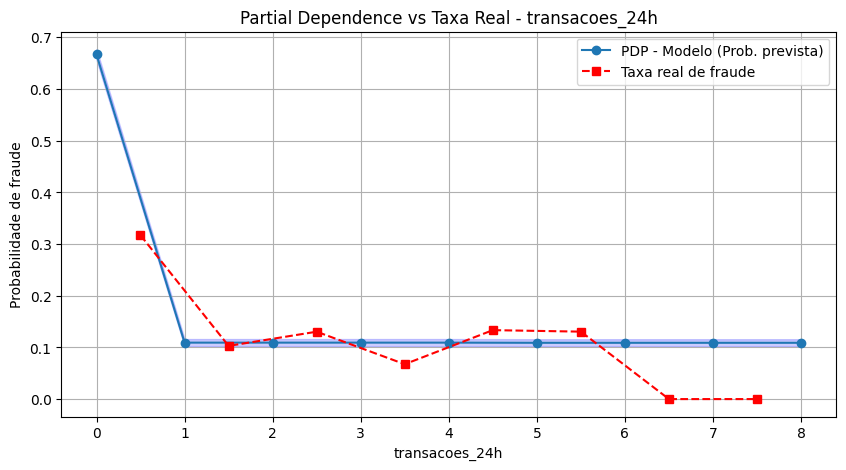

PartialDependencePlot progress: |

/tmp/ipython-input-40-3112716620.py:17: H2ODeprecationWarning: ``data`` param of ``ModelBase.partial_plot`` is deprecated, please use ``frame`` instead.
  pdp_result = gbm_model.partial_plot(


████████████████████████████████████████████████| (done) 100%


/tmp/ipython-input-40-3112716620.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_real.groupby(f'{feature}_bin')['fraude']


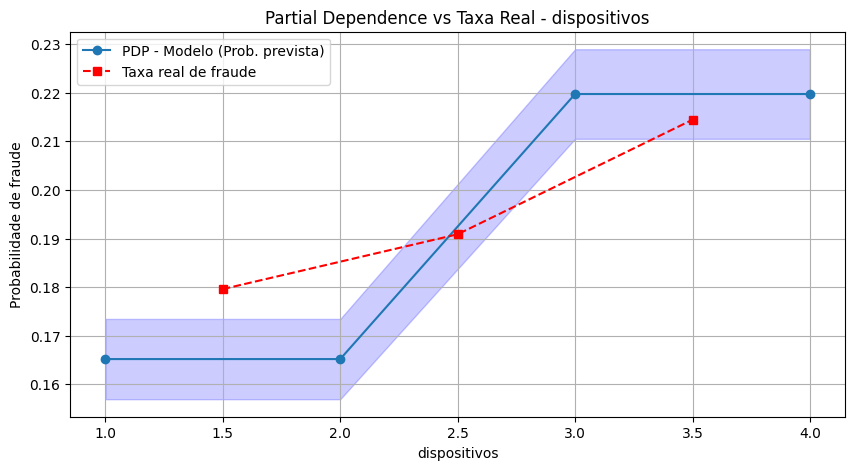

PartialDependencePlot progress: |

/tmp/ipython-input-40-3112716620.py:17: H2ODeprecationWarning: ``data`` param of ``ModelBase.partial_plot`` is deprecated, please use ``frame`` instead.
  pdp_result = gbm_model.partial_plot(


████████████████████████████████████████████████| (done) 100%


/tmp/ipython-input-40-3112716620.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_real.groupby(f'{feature}_bin')['fraude']


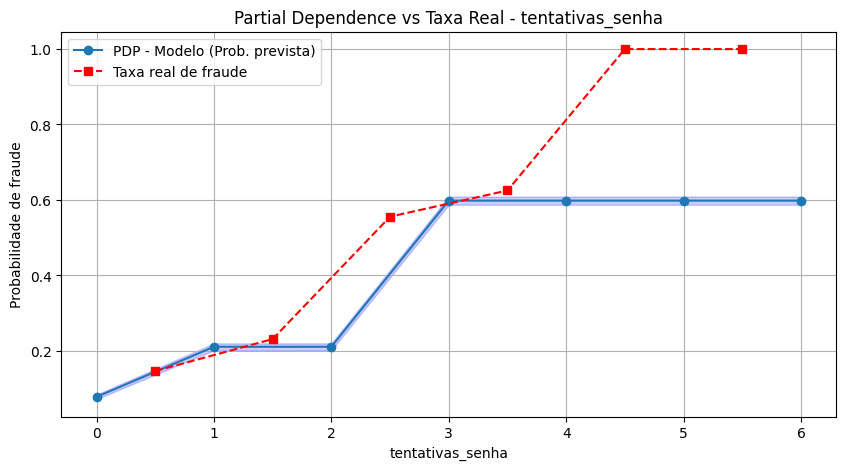

PartialDependencePlot progress: |

/tmp/ipython-input-40-3112716620.py:17: H2ODeprecationWarning: ``data`` param of ``ModelBase.partial_plot`` is deprecated, please use ``frame`` instead.
  pdp_result = gbm_model.partial_plot(


████████████████████████████████████████████████| (done) 100%


/tmp/ipython-input-40-3112716620.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_real.groupby(f'{feature}_bin')['fraude']


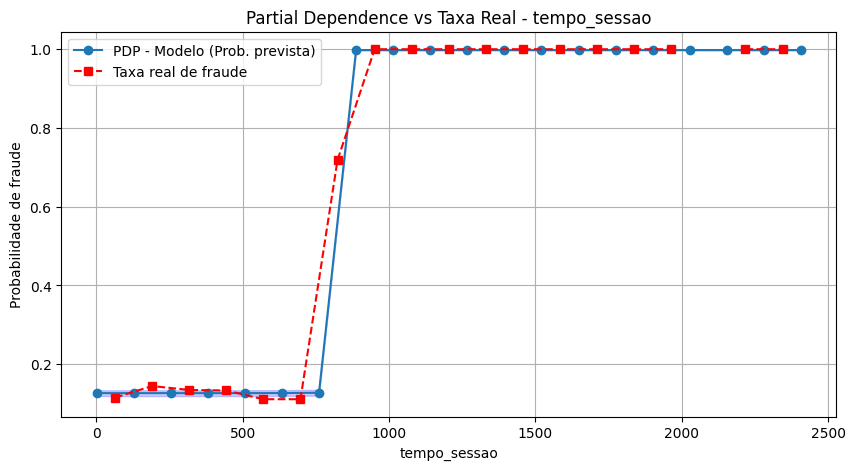

PartialDependencePlot progress: |

/tmp/ipython-input-40-3112716620.py:17: H2ODeprecationWarning: ``data`` param of ``ModelBase.partial_plot`` is deprecated, please use ``frame`` instead.
  pdp_result = gbm_model.partial_plot(


████████████████████████████████████████████████| (done) 100%


/tmp/ipython-input-40-3112716620.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_real.groupby(f'{feature}_bin')['fraude']


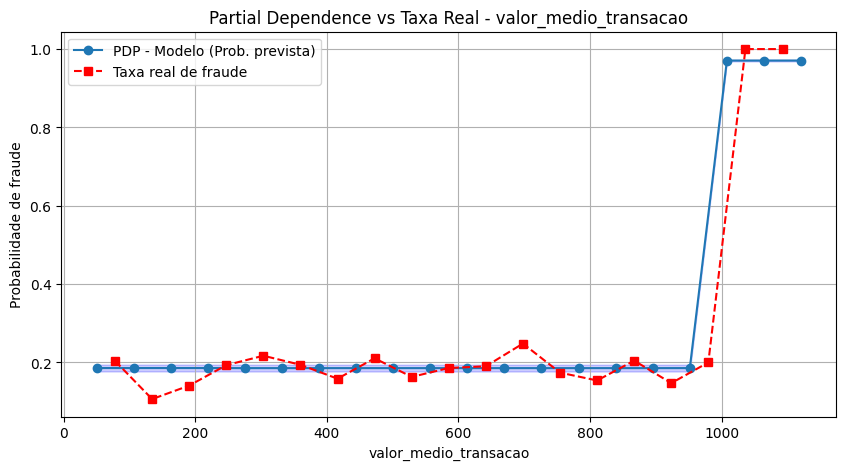

In [40]:
# ===============================
# 5. PDP para cada variável
# ===============================
import h2o
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Lista de variáveis do modelo (removendo target)
features = gbm_model._model_json['output']['names']
features.remove('fraude')

# Loop para todas as variáveis
for feature in features:
    try:
        # PDP para a variável
        pdp_result = gbm_model.partial_plot(
            data=hf,
            cols=[feature],
            plot=False
        )

        # Converter PDP para pandas
        pdp_df = pd.DataFrame(pdp_result[0].as_data_frame())

        # Calcular taxa real de fraude usando os mesmos bins
        df_real = df.copy()
        if feature not in df_real.columns:
            continue  # pula se a variável não existe no dataset original

        df_real[f'{feature}_bin'] = pd.cut(
            df_real[feature],
            bins=np.unique(pdp_df[feature]),
            include_lowest=True
        )
        fraud_rate_real = (
            df_real.groupby(f'{feature}_bin')['fraude']
            .mean()
            .reset_index()
        )
        fraud_rate_real['midpoint'] = fraud_rate_real[f'{feature}_bin'].apply(lambda x: x.mid)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(pdp_df[feature], pdp_df['mean_response'],
                 marker='o', label='PDP - Modelo (Prob. prevista)')
        plt.fill_between(
            pdp_df[feature],
            pdp_df['mean_response'] - pdp_df['std_error_mean_response'],
            pdp_df['mean_response'] + pdp_df['std_error_mean_response'],
            color='blue',
            alpha=0.2
        )

        plt.plot(fraud_rate_real['midpoint'], fraud_rate_real['fraude'],
                 marker='s', color='red', linestyle='--', label='Taxa real de fraude')

        plt.title(f'Partial Dependence vs Taxa Real - {feature}')
        plt.xlabel(feature)
        plt.ylabel('Probabilidade de fraude')
        plt.grid(True)
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Erro ao processar variável {feature}: {e}")



**Dados crus (taxa de fraude observada)**

* Suponha que, nos dados reais:

  * Usuários com tempo_sessao baixo (~100s) → 5% de fraude

  * Usuários com tempo_sessao médio (~400s) → 8% de fraude

  * Usuários com tempo_sessao muito alto (~1000s) → 30% de fraude

* Então, poderíamos concluir: “Quanto maior o tempo logado, maior a chance de fraude.”

**Detalhamento**

* O PDP pega cada observação da base e simula o que o modelo preveria se o tempo_sessao mudasse, mantendo as outras variáveis iguais.

* Vamos considerar o PDP para "tempo_sessao":
  * Ele pega uma lista de valores para tempo_sessao (por exemplo: 100, 400, 800, 1200 segundos).
  * Para cada valor, ele mantém todas as outras variáveis (tentativas_senha, dispositivos) iguais ao que estão na base e só troca tempo_sessao.
  * Ou seja:
    * Registro 1: tempo_sessao=800, tentativas_senha=0, dispositivos=1
    * Registro 2: tempo_sessao=800, tentativas_senha=1, dispositivos=1
    * Registro 3: tempo_sessao=800, tentativas_senha=2, dispositivos=1
    * Registro 4: tempo_sessao=800, tentativas_senha=0, dispositivos=2
    * Registro 5: tempo_sessao=800, tentativas_senha=1, dispositivos=2
    * Registro 6: tempo_sessao=800, tentativas_senha=2, dispositivos=2
    * Se nao houver uma combinação tentativas_senha=2, dispositivos=2, ele nao faz
  * E calcula a média de cada previsão

* Ao calcular a média das previsões para cada valor de tempo_sessao, o PDP pode mostrar, por exemplo:


| `tempo_sessao` (segundos) | Taxa real de fraude (%) | PDP - Modelo (%) |
| ------------------------- | ----------------------- | ---------------- |
| 100                       | 5                       | 7                |
| 400                       | 8                       | 10               |
| 800                       | 20                      | 12               |
| 1200                      | 30                      | 13               |


* Os dados reais sugerem que a fraude sobe muito acima de 800s.

* Mas o modelo não aprendeu isso com tanta força – ele acha que depois de 400s a chance de fraude fica quase estável (~12-13%).